In [69]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [114]:
attns = torch.load('/home/tanyang/workspace/DeepVaccine/result/ankh-large/VirusBinary/full/ESMFold_ankh-large_attention1d_5e-4_full__attentions.pt')[0][2].squeeze()
attns = attns[1:int(sum(attns > 0))]
attns.shape, sum(attns > 0)

/tmp/ipykernel_4176374/571376549.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attns = torch.load('/home/tanyang/workspace/DeepVaccine/result/ankh-large/VirusBinary/fu

(torch.Size([113]), tensor(113))

In [115]:
# smooth the attention with moving window average, attn shape: (1, seq_len)
def smooth_attention(attn, window_size=5):
    attn = attn.squeeze()
    attn = np.array(attn)
    attn = np.convolve(attn, np.ones(window_size)/window_size, mode='same')
    return attn

attns = torch.tensor(smooth_attention(attns, window_size=10))
attns.shape

torch.Size([113])

In [116]:
attns[0].unsqueeze(0).cpu().detach().numpy()

# open pdb file, and replace the bfactor with the attention score
pdb = open('/home/tanyang/workspace/DeepVaccine/dataset/CaseStudy/pdb/YP_009742616.1.pdb', 'r')
pdb_lines = pdb.readlines()
pdb.close()


# replace the bfactor with the attention score
for i in range(len(pdb_lines)):
    if pdb_lines[i].startswith('ATOM'):
        # same residue with different atoms have the same attention score
        current_residue_idx = int(pdb_lines[i][22:26].strip())
        pdb_lines[i] = pdb_lines[i][:60] +" "+ str(attns[current_residue_idx - 1].item()) + pdb_lines[i][66:]
        
        
        
        
# write the new pdb file
with open('YP_009742616.1_attn.pdb', 'w') as f:
    for line in pdb_lines:
        f.write(line)

# with open('attns.txt', 'w') as f:
#     for i in attns[0].squeeze().cpu().detach().numpy():
#         f.write(str(i) + '\n')

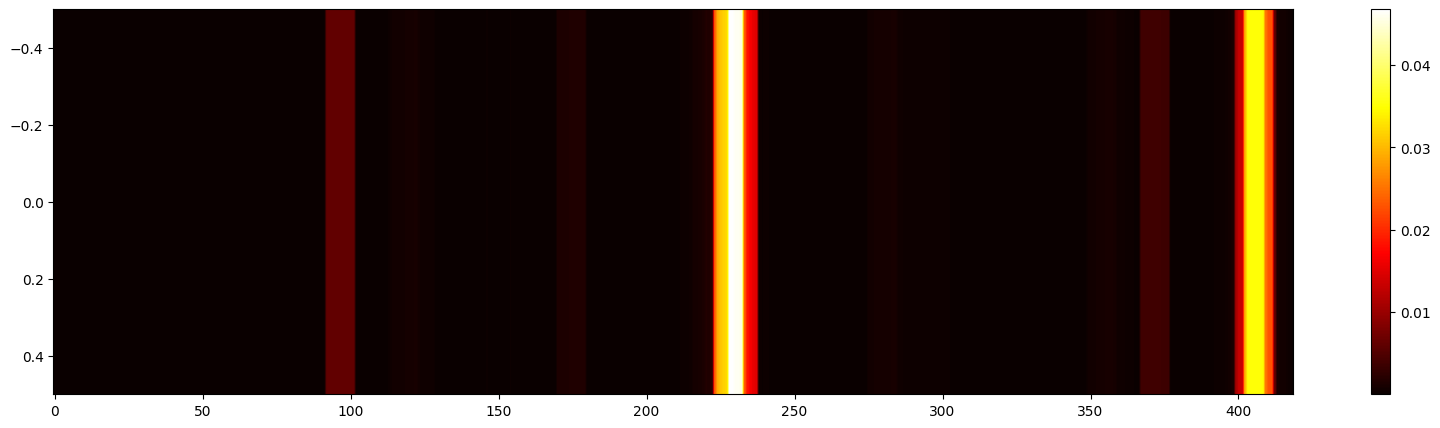

In [111]:
# draw 1d attention map
plt.figure(figsize=(20, 5))
plt.imshow(attns.unsqueeze(0), aspect='auto', cmap='hot')
plt.colorbar()
plt.show()


In [64]:
# select the top 10% of the attention scores
threshold = torch.quantile(attns[0], 0.9)
selected_residues = torch.where(attns[0] > threshold)[0]
selected_residues

tensor([  73,  147,  148,  248,  253,  297,  300,  330,  337,  338,  341,  342,
         365,  366,  367,  368,  369,  384,  407,  418,  419,  421,  439,  447,
         580,  601,  602,  603,  617,  621,  624,  626,  633,  752,  753,  754,
         755,  760,  761,  772,  775,  781,  782,  784,  785,  786,  787,  788,
         867,  869,  873,  874,  875,  891,  898,  899,  901,  902,  905,  906,
         908,  909,  910,  912,  924,  930,  931,  933,  934,  937,  938,  942,
         946,  948,  951,  952,  953,  954,  955,  956,  957,  959,  966,  967,
         973,  986,  990,  993,  997, 1001, 1004, 1009, 1010, 1011, 1012, 1013,
        1015, 1019, 1022, 1097, 1117, 1141, 1142, 1148, 1150, 1151, 1153, 1170,
        1172, 1174, 1179, 1180, 1182, 1183, 1186, 1187, 1190, 1193, 1194, 1213,
        1214, 1218, 1225, 1228, 1229, 1231, 1232, 1234])